In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_def = pd.read_csv('bmrp04_02_proportion_defensive.csv')
df_div = pd.read_csv('bmrp04_03_behavioural_diversity.csv')
df_with = pd.read_csv('bmrp04_01_proportion_within_2m.csv')

In [3]:
df_def[df_def['grp'] == '11']

,video,grp,stim,loc,field.grp.sz,stim.mean.propdef
0,11C1AM,11,c_scents,Core,15,0.300000
1,11C1AM,11,c_call,Core,15,0.066667
2,11C2AM,11,c_scents,Non-core,13,0.000000
3,11C2PM,11,c_intruders,Non-core,13,0.085034
4,11C3AM,11,c_scents,Core,12,0.083333
5,11C3PM,11,c_intruders,Core,12,0.000000
6,11R1PM,11,t_intruders,Core,15,0.634762
7,11R2PM,11,t_intruders,Non-core,15,0.245966
8,11R3AM,11,t_scents,Core,10,0.428571
9,11R3PM,11,t_intruders,Core,10,0.470238


In [4]:
df_div[df_div['grp'] == '11']

,video,grp,stim,loc,field.grp.sz,avg.h.bystim
0,11C1AM,11,c_scents,Core,15,0.494250
1,11C1AM,11,c_call,Core,15,0.676333
2,11C2AM,11,c_scents,Non-core,13,0.187333
3,11C2PM,11,c_intruders,Non-core,13,0.534286
4,11C3AM,11,c_scents,Core,12,0.737250
5,11C3PM,11,c_intruders,Core,12,0.340000
6,11R1PM,11,t_intruders,Core,15,0.736000
7,11R2PM,11,t_intruders,Non-core,15,0.888571
8,11R3AM,11,t_scents,Core,10,1.020333
9,11R3PM,11,t_intruders,Core,10,0.904286


In [5]:
df = pd.merge(df_def, df_div, on=['video','grp','field.grp.sz', 'loc', 'stim'])
df = pd.merge(df, df_with, on=['video','grp','field.grp.sz', 'loc', 'stim'])

In [6]:
df11 = df[df['grp'] == '11']
df.head(2)

,video,grp,stim,loc,field.grp.sz,stim.mean.propdef,avg.h.bystim,stim.mean.prop2m
0,11C1AM,11,c_scents,Core,15,0.3,0.494250,0.45
1,11C2AM,11,c_scents,Non-core,13,0.0,0.187333,0.25


In [7]:
from numpy.random import standard_normal as rnorm

ts = np.linspace(0, 2, 111)

N = len(df11)
Nt = len(ts)
dt = ts[1]-ts[0]
ks = df11['avg.h.bystim'].to_numpy() # gebejimas naudoti informacini lauka
kc = df11['stim.mean.propdef'].to_numpy() # socialinis aktyvumas
D = 0.001

In [8]:
def f(i, j, x):
    u = ks[i]*ks[j]+kc[i]*kc[j]
    return(np.exp(-(x[i]-x[j])**2/u**2)/(u*np.sqrt(np.pi)))

def phi(xi, xj):
    eps = 0.5
    return(np.exp(-(xi-xj)**2/eps**2)/(eps*np.sqrt(np.pi)))

def invDelta(i, j):
    eps = 5e-2
    if np.abs(i-j) <= eps:
        return(0)
    return(1)

def nextH(i, x, h, h0, dt, N):
    s = 0
    for j in range(0, N):
        if j != i:
            s += f(i, j, x)*phi(x[i], x[j])*\
                    invDelta(ks[i]+ks[j], kc[i]+kc[j])
    return(h[i] + D*(h[i]-h0[i]) + s*dt)

def nextX(i, x, xm1, h, hm1, dt, N):
    s = 0
    for j in range(1, N):
        if j != i:
            dHj = h[j] - hm1[j] # dabartis-praeitis vietoje ateitis-dabartis
            dxj = x[j] - xm1[j] # dabartis-praeitis vietoje ateitis-dabartis
            if dxj != 0:
                s += dHj/dxj
    s *= ks[i]*kc[i]
    s += np.sqrt(2*D)*rnorm(1)[0]
    return(x[i] + s*dt)

In [9]:
# h(x_i, t) := h(x_1, x_2), t - mintyje

res = []
for epoch in range(20):
    print("epocha:", epoch)
    
    # Tarkime, is pradziu visi individai nenaudoja informacinio lauko / ramus laukas
    h = np.zeros([N, 1]) # t = 0
    h0 = h
    hm1 = h.copy() # informacinis laukas ankstesniu laiko periodu
    hs = [h.copy()]
    x = kc
    xm1 = x.copy() # individu pozicijos ankstesniu laiko periodu
    xs = [x.copy()]
    
    for it in range(Nt-1):

        # Informacinio lauko atnaujinimas (integravimas pirmyn)
        hm1 = h.copy()
        for i in range(N):
            h[i] = nextH(i, x, h, h0, dt, N) 
        #print(hm1, "=>", h)
        hs.append(h.copy())

        # Individu uzimamu poziciju atnaujinimass (integravimas pirmyn)
        xm1 = x.copy()
        for i in range(N):
            x[i] = nextX(i, x, xm1, h, hm1, dt, N)
        #print(xm1, "=>", x)
        xs.append(x.copy())

        #print(np.diff(xm1), "=>", np.diff(x))
    
    res.append([xs, hs])

epocha: 0
epocha: 1
epocha: 2
epocha: 3
epocha: 4
epocha: 5
epocha: 6
epocha: 7
epocha: 8
epocha: 9
epocha: 10
epocha: 11
epocha: 12
epocha: 13
epocha: 14
epocha: 15
epocha: 16
epocha: 17
epocha: 18
epocha: 19


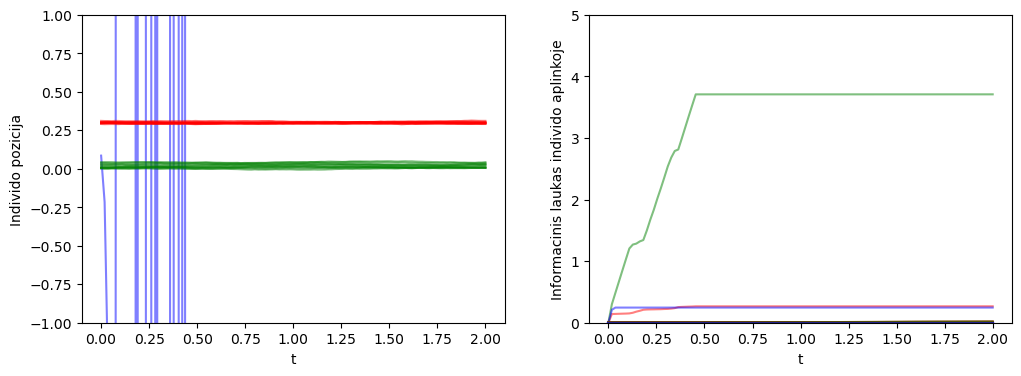

In [11]:
fig, ax = plt.subplots(1, 2, figsize=[12, 4])

for epoch in range(10):
    xs = res[epoch][0]
    xs = np.array(xs)
    ax[0].plot(ts, xs[:,0], 'r', alpha=0.5)
    ax[0].plot(ts, xs[:,1], 'g', alpha=0.5)
    ax[0].plot(ts, xs[:,2], 'b', alpha=0.5)
    ax[0].set_ylabel("Individo pozicija")
    ax[0].set_xlabel("t")
    
    hs = res[epoch][1]
    hs = np.array(hs)
    ax[1].plot(ts, hs[:,0], 'r', alpha=0.5)
    ax[1].plot(ts, hs[:,1], 'g', alpha=0.5)
    ax[1].plot(ts, hs[:,2], 'b', alpha=0.5)
    ax[1].set_ylabel("Informacinis laukas individo aplinkoje")
    ax[1].set_xlabel("t")
ax[0].set_ylim([-1,1])
ax[1].set_ylim([0,5])
plt.show()